In [232]:
#imports and constants
import time
import math 
from urllib.request import urlretrieve as rx
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
EarthRadius = 6378137
MinLatitude = -85.05112878
MaxLatitude = 85.05112878
MinLongitude = -180
MaxLongitude = 180
MaxLevelofDetail=23
MaxSize=7000

In [263]:
def Clip(n, minValue, maxValue):
    """
    Clips a number to the specified minimum and maximum values
    input number and its min&max range
    output clipped value in range min and max"""
    return min(max(n,minValue),maxValue)

def MapSize(levelofDetail):
    """
    Determines the map width and height (in pixels) at a specified level
    of detail //map width = map height = 256 * 2pow(level) pixels
    input level of detail 1 to 23
    output returns height=width of map"""
    return int(256 << levelofDetail)

def GroundResolution(latitude,levelofDetail):
    """ 
    Determines the ground resolution (in meters per pixel) at a specified
    latitude and level of detail.
    input latitude,level of detail
    output ground resolution in meters per pixel"""
    latitude=Clip(latitude,MinLatitude,MaxLatitude)
    return math.cos(latitude * math.pi / 180) * 2 * math.pi * EarthRadius / MapSize(levelofDetail)

def MapScale(latitude,levelofDetail,screenDpi):
    """
    Determines the map scale at a specified latitude, level of detail,
    and screen resolution.
    input latitude,levelofDetail,screenDpi
    output mapscale"""
    return GroundResolution(latitude,levelofDetail)*screenDpi/0.0254

def LatLongToPixelXY(latitude,longitude,levelofDetail):
    """
    Converts a point from latitude/longitude WGS-84 coordinates (in degrees)
    into pixel XY coordinates at a specified level of detail.
    input latitude,level of detail,screen dpi
    output pixelX, pixelY"""
    latitude = Clip(latitude, MinLatitude, MaxLatitude)
    longitude = Clip(longitude, MinLongitude, MaxLongitude)
    
    x=(longitude+180)/360
    sinLatitude=math.sin(latitude*math.pi/180)
    y=0.5-math.log((1 + sinLatitude) / (1 - sinLatitude))/(4*math.pi)
    
    mapSize=MapSize(levelofDetail)
    pixelX=Clip(x*mapSize+0.5,0,mapSize-1)
    pixelY=Clip(y*mapSize+0.5,0,mapSize-1)
    return int(pixelX),int(pixelY)

def pixelXYToTileXY(pixelX,pixelY):
    """
     Converts pixel XY coordinates into tile XY coordinates of the tile containing
    the specified pixel.
    input :pixelX,pixelY
    output:tileX,tileY
    """
    tileX=pixelX/256
    tileY=pixelY/256
    return int(tileX),int(tileY)

def TileXYToQuadKey(tileX,tileY,levelofDetail):
    """
    Converts tile XY coordinates into a QuadKey at a specified level of detail.
    input:tileX,tileYlevel of detail
    output: quadkey string"""
    quadKey=[]
    for i in range(levelofDetail,0,-1):
        digit=0
        mask=1 <<(i-1)
        if (tileX & mask)!=0:
            digit+=1
        if (tileY & mask)!=0:
            digit+=1
            digit+=1
        quadKey.append(str(digit))
    return "".join(quadKey)

def order(x1,y1,x2,y2):
    """
    orders given pair 
    input:2 pairs of lat,long or tile cordinates
    output: same cordinates but ordered
    """
    if x1>x2:
        temp=x1
        x1=x2
        x2=temp
    if y1>y2:
        temp=y1
        y1=y2
        y2=temp
    return x1,y1,x2,y2

def find_MaxLevelofDetail(lat,long):
    """finds the higest resolution/levelofDetail image available
    input:latitude,longitude
    output:returns depth
    """
    for i in range(MaxLevelofDetail,1,-1):
        quadkey,img=get_img(lat,long,i)
        if np.array_equal(img,plt.imread("empty.jpeg")):
            {}#find the next lower levelofDetail img
        else:
            break       
    return i
    
def get_LevelofDetail(lat1,long1,lat2,long2,part=3):
    """
    divides the bounding box in grids-part*part along lat,long to get 
    sample points followed by their max levelofDetail 
    input ordered 2 pair of lat,long coordinates & # of partations to make
    output min levelofDetails among all imgs of max levelofdetail for sample points
    """
    f=[]
    delta_x=(lat2-lat1)/part
    delta_y=(long2-long1)/part
    i=lat1
    while i<=lat2:
        j=long1
        while j<=long2:
            f.append(find_MaxLevelofDetail(i,j))
            j+=delta_y
        i+=delta_x
    return min(f)

def img_size(pixelx1,pixely1,pixelx2,pixely2):
    """finds image size given 2 pair of pixel coordinates
    input 2 pairs of pixel coordinates
    output image size in KB
    """
    delta_X=abs(pixelx1-pixelx2)
    delta_Y=abs(pixely1-pixely2)
    num_of_pixels=delta_X*delta_Y
    #size per pixel is 24 bytes RGB
    return (num_of_pixels*24)/1000

def retrive_img(q):
    """retrive img for give quadkey 
    input quadkey
    output img"""
    part1_url=" http://h0.ortho.tiles.virtualearth.net/tiles/h"
    part2_url=".jpeg?g=131"
    rx(part1_url+q+part2_url,"temp.jpeg")
    img=plt.imread("temp.jpeg")
    if np.array_equal(img,plt.imread("empty.jpeg")):
        print("error maxlevel selected didnt work make more sample points passing higher part value for get_LevelofDetail fun")
    else:
        return img

enter lat long coordinates as: lat1<space>long1<space>lat2<space>long2
41.8786 -87.7531 41.8781 -87.7538
maxlevel 20
img size 6276.528 KB max limit 7000 KB


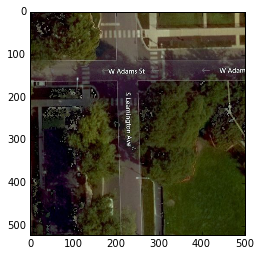

In [275]:
def main():
    #default coordinates
    lat1=41.8786
    long1=-87.7531

    #chicago
    lat2=41.8781
    long2=-87.7538
    
    final_img=vertical_img=[]
    q=""
    
    #take input coordinates & size
    print("enter lat long coordinates as: lat1<space>long1<space>lat2<space>long2")
    lat1,long1,lat2,long2=(float(i) for i in input().split(" "))
    if lat1==lat2 or long1==long2:
        print("select coordinates not on same line ")
        return
    else:
        maxlevel=get_LevelofDetail(*order(lat1,long1,lat2,long2))
        print("maxlevel",maxlevel)
        
        #checking img size
        pixelx1,pixely1=LatLongToPixelXY(lat1,long1,maxlevel)
        pixelx2,pixely2=LatLongToPixelXY(lat2,long2,maxlevel)
        
        size=img_size(pixelx1,pixely1,pixelx2,pixely2)
        print("img size",size,"KB","max limit",MaxSize,"KB")
        if size>MaxSize:
            print("region too large select smaller region or change MaxSize")
        else:
           
            tilex1,tiley1=pixelXYToTileXY(pixelx1,pixely1)
            tilex2,tiley2=pixelXYToTileXY(pixelx2,pixely2)
            
            tilex1,tiley1,tilex2,tiley2=order(tilex1,tiley1,tilex2,tiley2)
            #retriving tiles
            for x in range(tilex1,tilex2+1):
                for y in range(tiley1,tiley2+1):
                    q=TileXYToQuadKey(x,y,maxlevel)
                    if len(vertical_img)!=0:
                        vertical_img=np.concatenate((vertical_img,retrive_img(q)),axis=0)
                    else:
                        vertical_img=retrive_img(q)
                if len(final_img)!=0:
                    final_img=np.concatenate((final_img,vertical_img),axis=1)
                else:
                    final_img=vertical_img
                vertical_img=[]
                
            
            #croping
            #shifting origin to tilex1,tiley1
            pixelx1-=(tilex1*256)
            pixelx2-=(tilex1*256)
            pixely1-=(tiley1*256)
            pixely2-=(tiley1*256)
            
            #slice
            pixelx1,pixely1,pixelx2,pixely2=order(pixelx1,pixely1,pixelx2,pixely2)
            final_img=final_img[pixelx1:pixelx2, pixely1:pixely2]
            plt.imshow(final_img)
            plt.imsave("final_img.jpeg",final_img)
if __name__ == "__main__":
    main()